# UNet model

Running the UNet from here 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff


import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

/home/CharlesAkin-David/cs231n_bmi260_project/Pytorch-UNet/utils/data_vis.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in sta

In [2]:
NUM_TOTAL = 885
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Train',
                          root_dir='../Cyst_Dataset/Train',
                          mask=True, HU=True, resize=256)

lung_dataset_test = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Test',
                          root_dir='../Cyst_Dataset/Test',
                          mask=True, HU=True, resize=256)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=4)

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Check Accuracy

In [4]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [5]:
def eval_net(net, loader, device, gpu=False):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on test set')   

    tot = 0
    cntr = 0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)

            y_pred = (F.sigmoid(y_pred) > 0.6).float()
#             print(y_pred.squeeze(1).squeeze(1).shape)
#             dice = dice_coeff(y_pred, y.float()).data[0]
#             print(dice.shape)
            dice = dice_loss(y_pred, y)
            tot += dice
            cntr += 1
            
            if 0:
                X = X.data.squeeze(1).cpu().numpy()
                print('X', X.shape)
                X = np.transpose(X, axes=[1, 2, 0])
                print('X.T', X.shape)
                y = y.data.squeeze(1).cpu().numpy()
                print('y', y.shape)
                y = np.transpose(y, axes=[1, 2, 0])
                print('y.T', y.shape)
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])
                print(y_pred.shape)

                fig = plt.figure()
                ax1 = fig.add_subplot(1, 4, 1)
                ax1.imshow(X)
                ax2 = fig.add_subplot(1, 4, 2)
                ax2.imshow(y)
                ax3 = fig.add_subplot(1, 4, 3)
                ax3.imshow((y_pred > 0.5))
                
                y_pred = np.transpose(y_pred, axes=[2, 0, 1])
                Q = dense_crf(((X[0] * 255).round()).astype(np.uint8), y_pred[0])
                ax4 = fig.add_subplot(1, 4, 4)
                print(Q)
                ax4.imshow(Q > 0.5)
                plt.show()
    return tot / cntr

# Train

In [9]:
#Train function

def train_net(net, epochs=50, batch_size=5, lr=1e-3, val_percent=0.05, save=True, gpu=True):
    optimizer = optim.SGD(net.parameters(),
                          lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                net.cuda()
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
            
            probs = F.sigmoid(y_pred)
            probs_flat = probs.view(-1)

            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            epoch_loss += loss.data[0]

            if(t%100 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
                print(y_pred.shape)
                print("X")
                plt.imshow(X.data.cpu().numpy()[0,0,:], cmap='gray')
                plt.show()
                print("Predicted Y")
                plt.imshow(y_pred.data.cpu().numpy()[0,0,:], cmap='gray')
                plt.show()
                print("Actual Y")
                plt.imshow(y.data.cpu().numpy()[0,0,:], cmap='gray')
                plt.show()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
#             plt.imshow(val_dice.data.cpu().numpy(), cmap='gray')
#             plt.show()

        if save:
            torch.save(net.state_dict(),
                       dir_checkpoint + 'batch_4/CP{}.pth'.format(epoch + 1))

            print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/50.
0.0000 --- loss: 0.781180
torch.Size([4, 1, 256, 256])
X


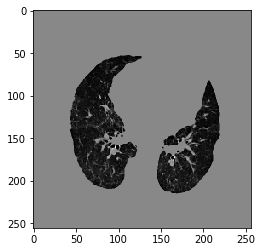

Predicted Y


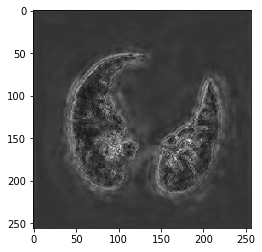

Actual Y


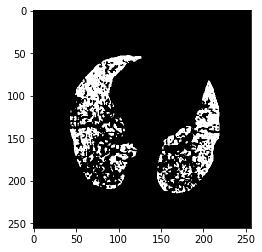

100.0000 --- loss: 0.330535
torch.Size([4, 1, 256, 256])
X


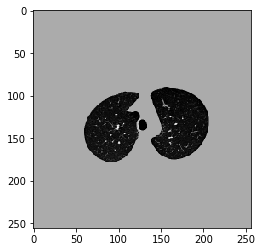

Predicted Y


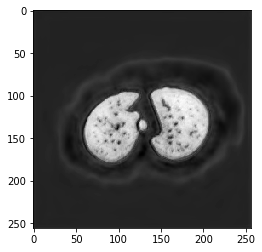

Actual Y


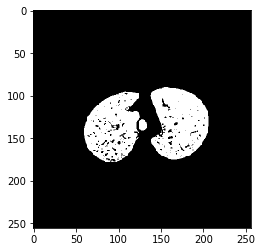

Epoch finished ! Loss: 0.41139480471611023
Checking accuracy on test set
Validation Dice Coeff: 0.036895912140607834
Checkpoint 1 saved !
Starting epoch 2/50.
0.0000 --- loss: 0.217054
torch.Size([4, 1, 256, 256])
X


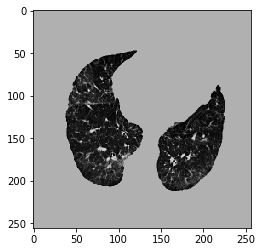

Predicted Y


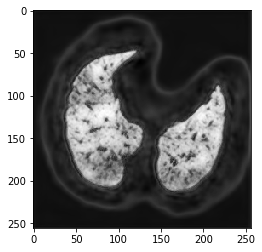

Actual Y


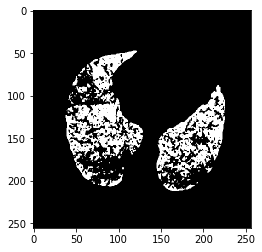

100.0000 --- loss: 0.136554
torch.Size([4, 1, 256, 256])
X


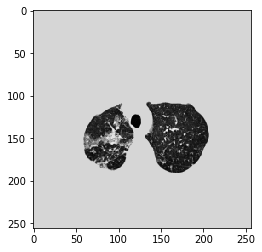

Predicted Y


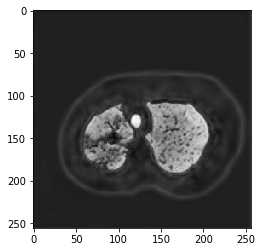

Actual Y


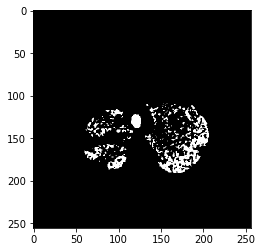

Epoch finished ! Loss: 0.15121549367904663
Checking accuracy on test set
Validation Dice Coeff: 0.031826090067625046
Checkpoint 2 saved !
Starting epoch 3/50.
0.0000 --- loss: 0.104844
torch.Size([4, 1, 256, 256])
X


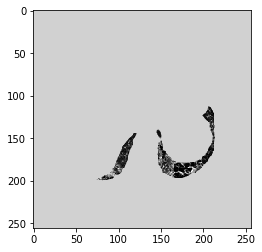

Predicted Y


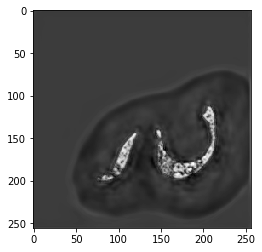

Actual Y


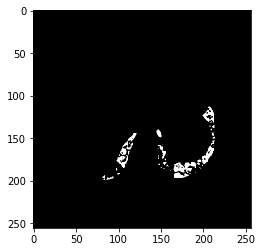

100.0000 --- loss: 0.079110
torch.Size([4, 1, 256, 256])
X


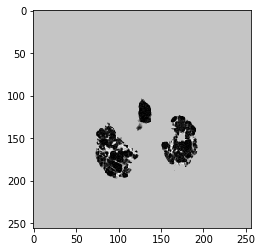

Predicted Y


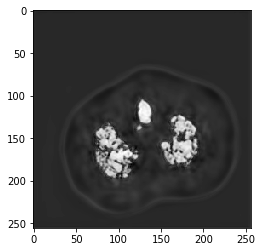

Actual Y


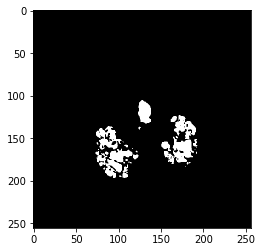

Epoch finished ! Loss: 0.10162465274333954
Checking accuracy on test set
Validation Dice Coeff: 0.038702987134456635
Checkpoint 3 saved !
Starting epoch 4/50.
0.0000 --- loss: 0.074242
torch.Size([4, 1, 256, 256])
X


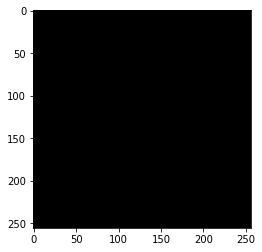

Predicted Y


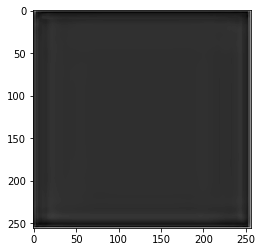

Actual Y


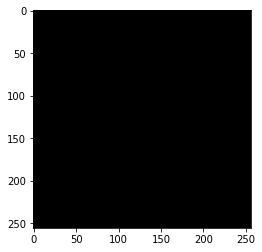

100.0000 --- loss: 0.071843
torch.Size([4, 1, 256, 256])
X


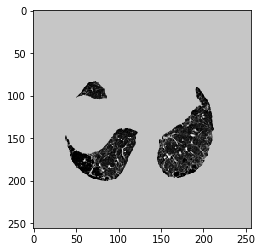

Predicted Y


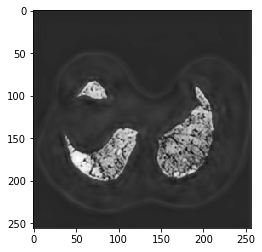

Actual Y


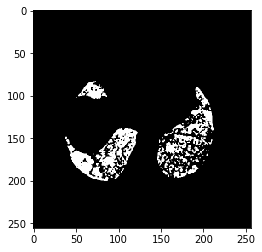

Epoch finished ! Loss: 0.07982388138771057
Checking accuracy on test set
Validation Dice Coeff: 0.018975993618369102
Checkpoint 4 saved !
Starting epoch 5/50.
0.0000 --- loss: 0.064659
torch.Size([4, 1, 256, 256])
X


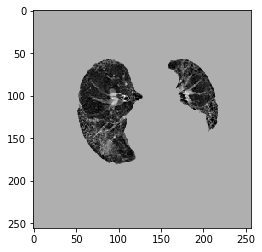

Predicted Y


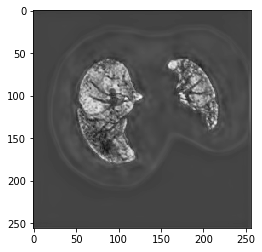

Actual Y


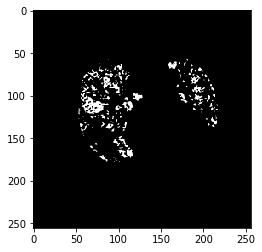

100.0000 --- loss: 0.103675
torch.Size([4, 1, 256, 256])
X


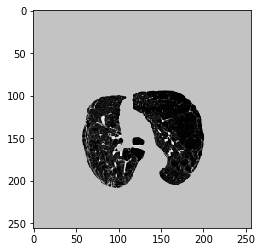

Predicted Y


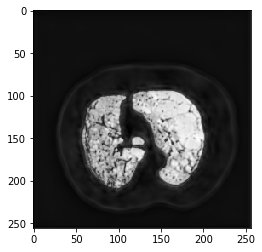

Actual Y


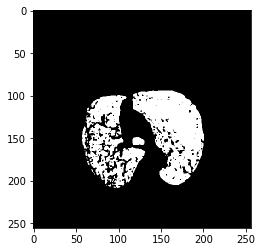

Epoch finished ! Loss: 0.06990257650613785
Checking accuracy on test set
Validation Dice Coeff: 0.028487641364336014
Checkpoint 5 saved !
Starting epoch 6/50.
0.0000 --- loss: 0.074637
torch.Size([4, 1, 256, 256])
X


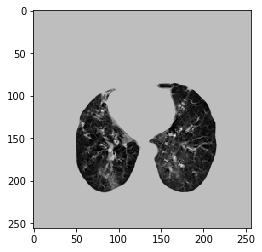

Predicted Y


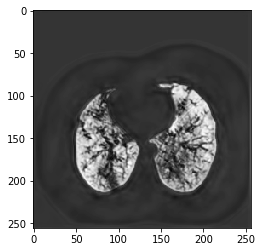

Actual Y


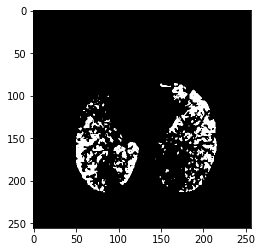

100.0000 --- loss: 0.073272
torch.Size([4, 1, 256, 256])
X


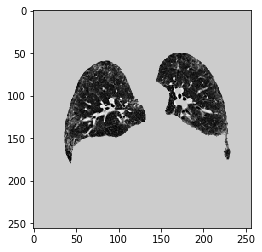

Predicted Y


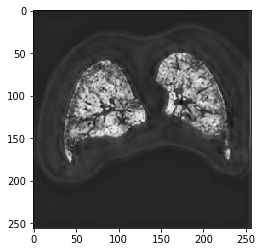

Actual Y


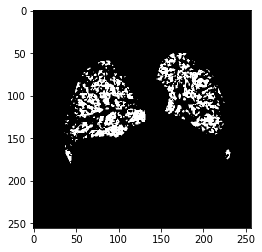

Epoch finished ! Loss: 0.06387854367494583
Checking accuracy on test set
Validation Dice Coeff: 0.015922050923109055
Checkpoint 6 saved !
Starting epoch 7/50.
0.0000 --- loss: 0.049376
torch.Size([4, 1, 256, 256])
X


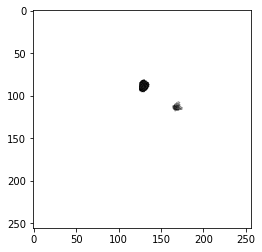

Predicted Y


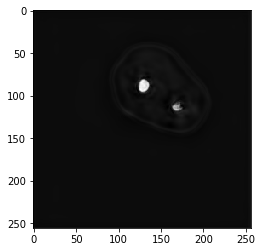

Actual Y


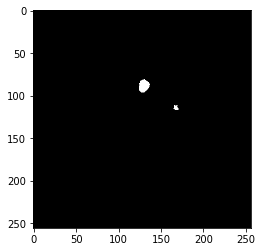

100.0000 --- loss: 0.054388
torch.Size([4, 1, 256, 256])
X


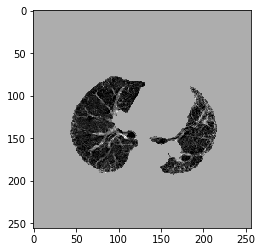

Predicted Y


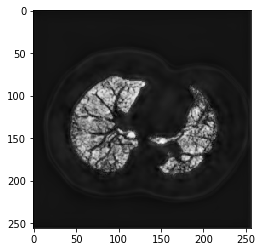

Actual Y


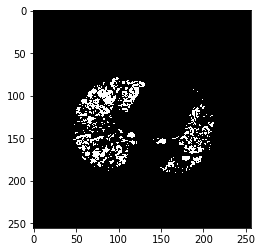

Epoch finished ! Loss: 0.060950689017772675
Checking accuracy on test set
Validation Dice Coeff: 0.040790021419525146
Checkpoint 7 saved !
Starting epoch 8/50.
0.0000 --- loss: 0.072648
torch.Size([4, 1, 256, 256])
X


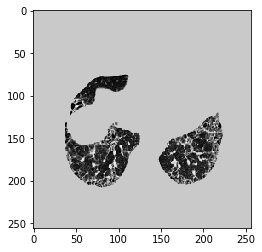

Predicted Y


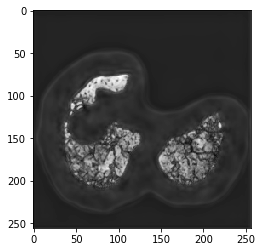

Actual Y


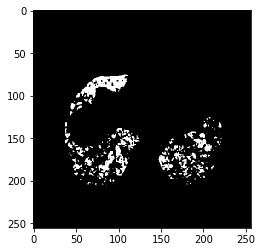

100.0000 --- loss: 0.062919
torch.Size([4, 1, 256, 256])
X


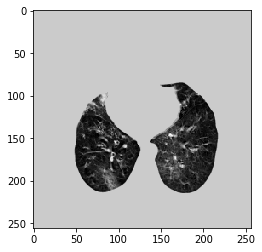

Predicted Y


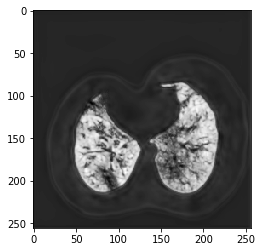

Actual Y


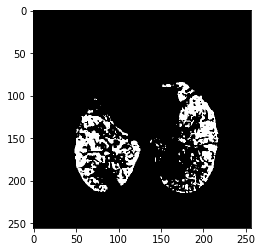

Epoch finished ! Loss: 0.056790538132190704
Checking accuracy on test set
Validation Dice Coeff: 0.019660038873553276
Checkpoint 8 saved !
Starting epoch 9/50.
0.0000 --- loss: 0.046399
torch.Size([4, 1, 256, 256])
X


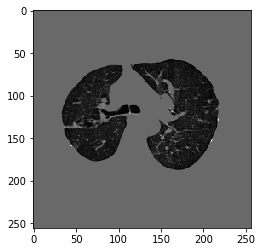

Predicted Y


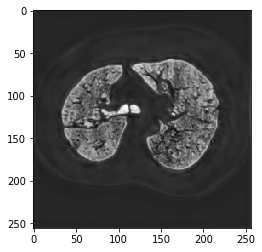

Actual Y


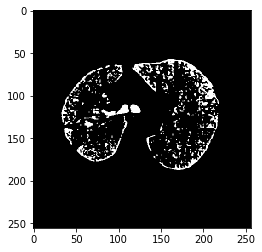

100.0000 --- loss: 0.046036
torch.Size([4, 1, 256, 256])
X


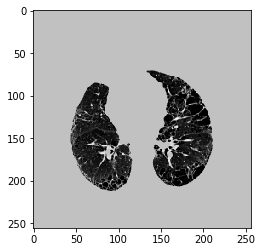

Predicted Y


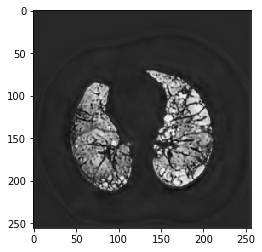

Actual Y


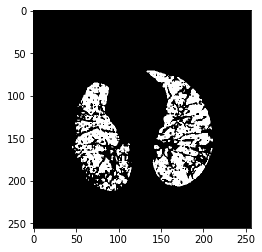

Epoch finished ! Loss: 0.05400387942790985
Checking accuracy on test set
Validation Dice Coeff: 0.05872742831707001
Checkpoint 9 saved !
Starting epoch 10/50.
0.0000 --- loss: 0.055015
torch.Size([4, 1, 256, 256])
X


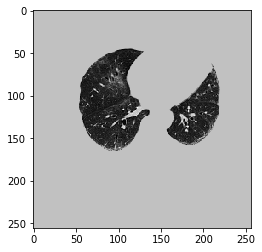

Predicted Y


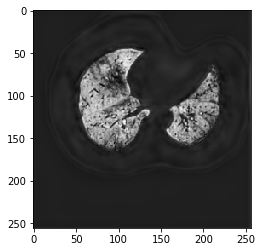

Actual Y


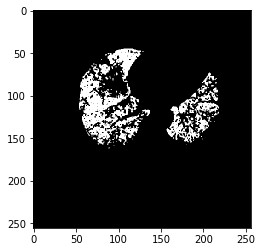

100.0000 --- loss: 0.062085
torch.Size([4, 1, 256, 256])
X


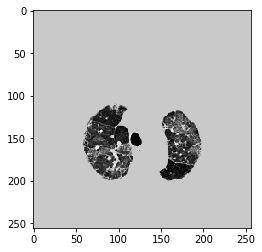

Predicted Y


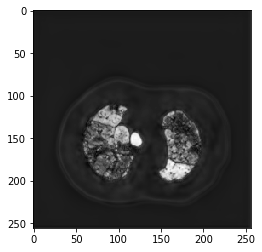

Actual Y


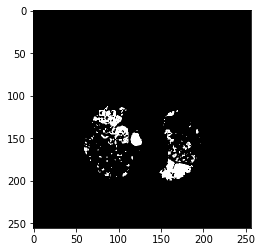

Epoch finished ! Loss: 0.0511927492916584
Checking accuracy on test set
Validation Dice Coeff: 0.021368008106946945
Checkpoint 10 saved !
Starting epoch 11/50.
0.0000 --- loss: 0.048293
torch.Size([4, 1, 256, 256])
X


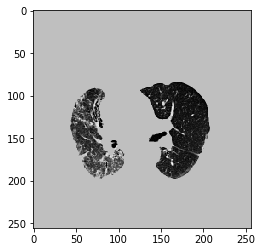

Predicted Y


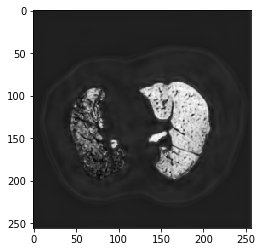

Actual Y


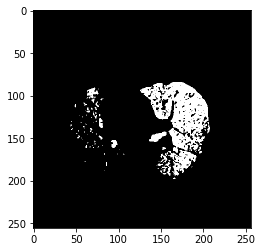

100.0000 --- loss: 0.052689
torch.Size([4, 1, 256, 256])
X


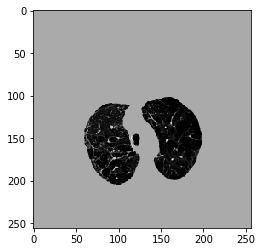

Predicted Y


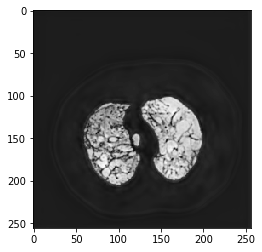

Actual Y


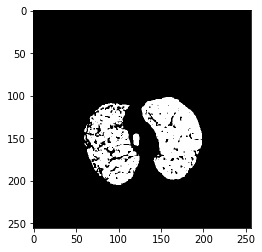

Epoch finished ! Loss: 0.05022410303354263
Checking accuracy on test set
Validation Dice Coeff: 0.01789955422282219
Checkpoint 11 saved !
Starting epoch 12/50.
0.0000 --- loss: 0.061130
torch.Size([4, 1, 256, 256])
X


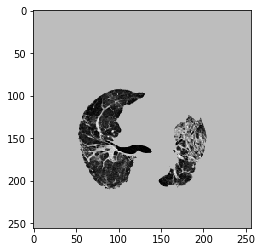

Predicted Y


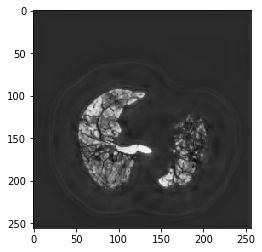

Actual Y


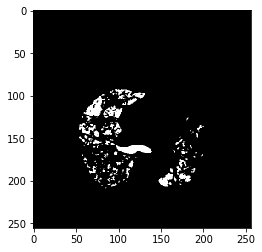

100.0000 --- loss: 0.062345
torch.Size([4, 1, 256, 256])
X


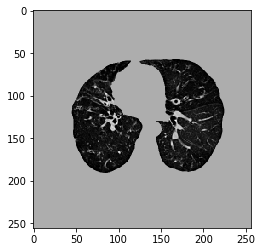

Predicted Y


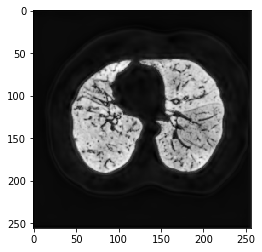

Actual Y


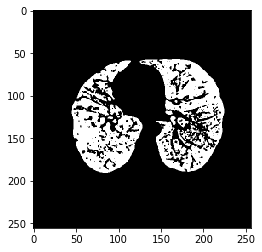

Epoch finished ! Loss: 0.04943830519914627
Checking accuracy on test set
Validation Dice Coeff: 0.04098781570792198
Checkpoint 12 saved !
Starting epoch 13/50.
0.0000 --- loss: 0.060236
torch.Size([4, 1, 256, 256])
X


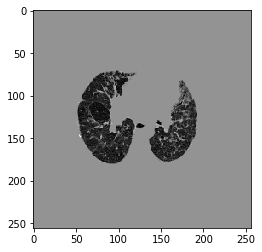

Predicted Y


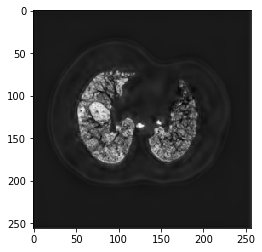

Actual Y


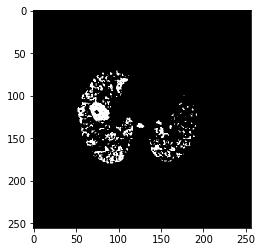

100.0000 --- loss: 0.053189
torch.Size([4, 1, 256, 256])
X


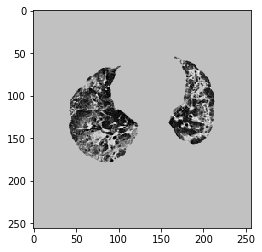

Predicted Y


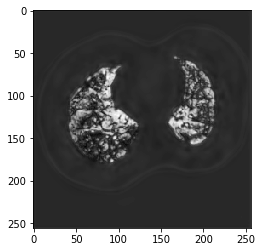

Actual Y


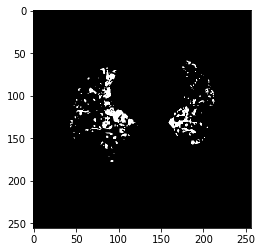

Epoch finished ! Loss: 0.047202352434396744
Checking accuracy on test set
Validation Dice Coeff: 0.020672783255577087
Checkpoint 13 saved !
Starting epoch 14/50.
0.0000 --- loss: 0.044711
torch.Size([4, 1, 256, 256])
X


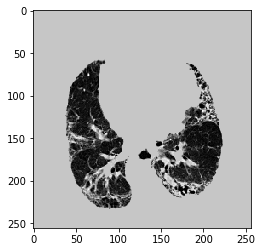

Predicted Y


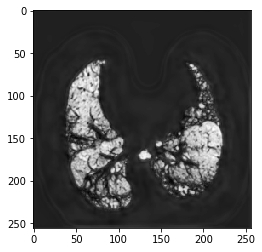

Actual Y


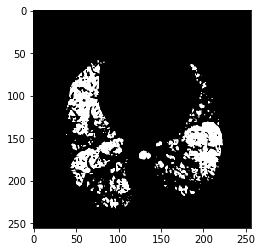

100.0000 --- loss: 0.036806
torch.Size([4, 1, 256, 256])
X


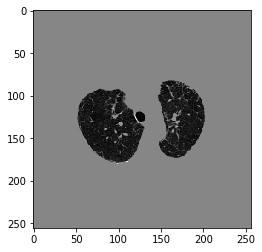

Predicted Y


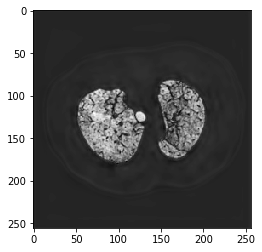

Actual Y


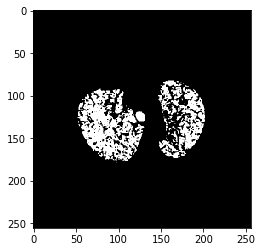

Epoch finished ! Loss: 0.04639774188399315
Checking accuracy on test set
Validation Dice Coeff: 0.032339587807655334
Checkpoint 14 saved !
Starting epoch 15/50.
0.0000 --- loss: 0.026010
torch.Size([4, 1, 256, 256])
X


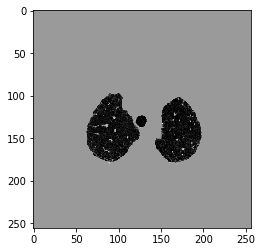

Predicted Y


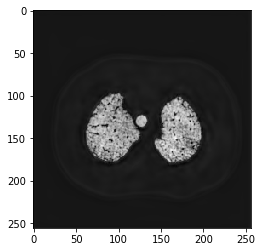

Actual Y


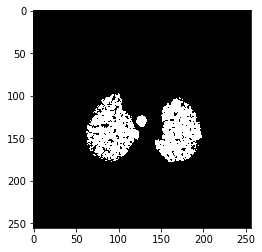

100.0000 --- loss: 0.025947
torch.Size([4, 1, 256, 256])
X


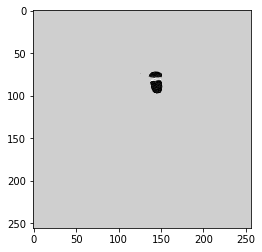

Predicted Y


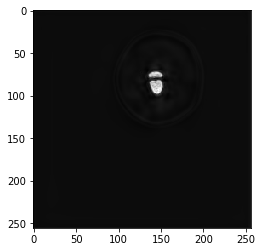

Actual Y


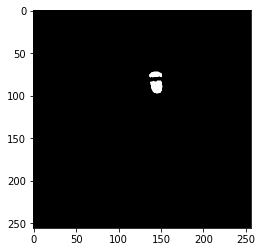

Epoch finished ! Loss: 0.045448869466781616
Checking accuracy on test set
Validation Dice Coeff: 0.023798003792762756
Checkpoint 15 saved !
Starting epoch 16/50.
0.0000 --- loss: 0.046045
torch.Size([4, 1, 256, 256])
X


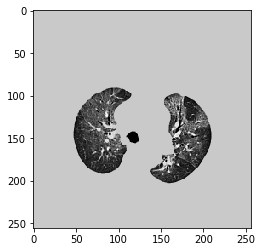

Predicted Y


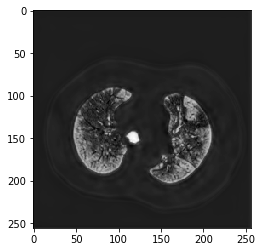

Actual Y


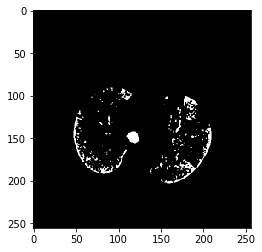

100.0000 --- loss: 0.029494
torch.Size([4, 1, 256, 256])
X


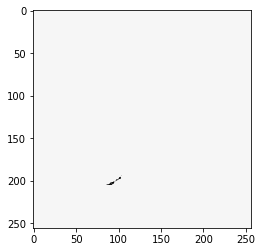

Predicted Y


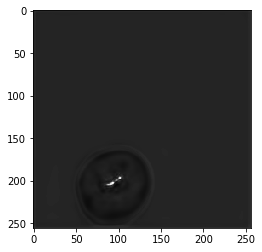

Actual Y


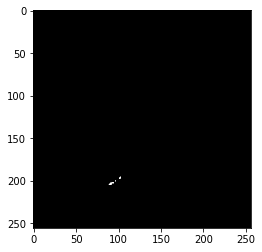

Epoch finished ! Loss: 0.045096833258867264
Checking accuracy on test set
Validation Dice Coeff: 0.03542691096663475
Checkpoint 16 saved !
Starting epoch 17/50.
0.0000 --- loss: 0.048065
torch.Size([4, 1, 256, 256])
X


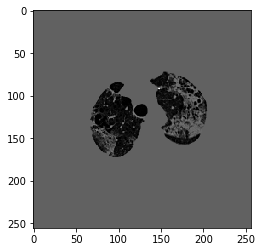

Predicted Y


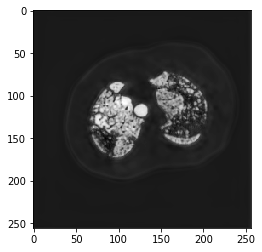

Actual Y


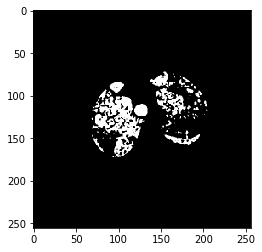

100.0000 --- loss: 0.059494
torch.Size([4, 1, 256, 256])
X


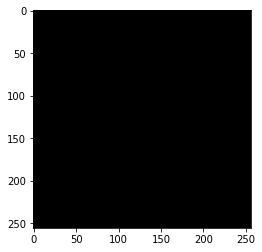

Predicted Y


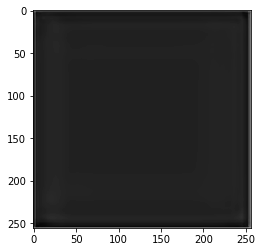

Actual Y


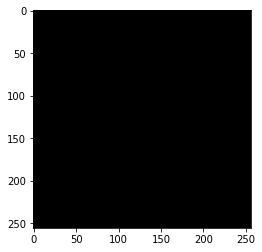

Epoch finished ! Loss: 0.04483673349022865
Checking accuracy on test set
Validation Dice Coeff: 0.027301974594593048
Checkpoint 17 saved !
Starting epoch 18/50.
0.0000 --- loss: 0.037498
torch.Size([4, 1, 256, 256])
X


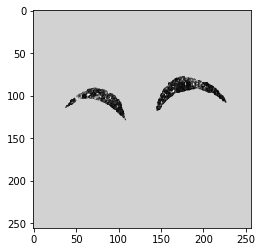

Predicted Y


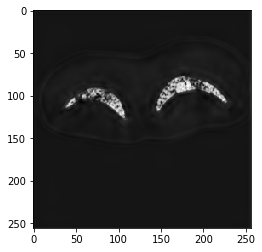

Actual Y


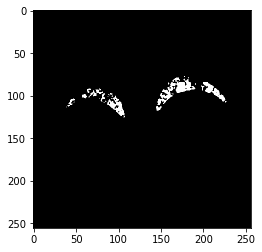

100.0000 --- loss: 0.036662
torch.Size([4, 1, 256, 256])
X


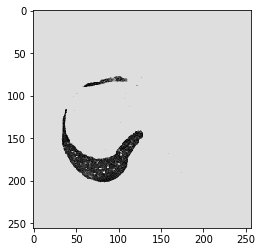

Predicted Y


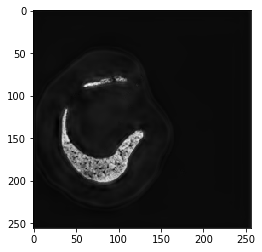

Actual Y


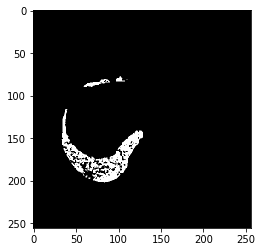

Epoch finished ! Loss: 0.04333609342575073
Checking accuracy on test set
Validation Dice Coeff: 0.06873200088739395
Checkpoint 18 saved !
Starting epoch 19/50.
0.0000 --- loss: 0.059863
torch.Size([4, 1, 256, 256])
X


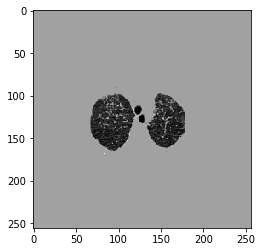

Predicted Y


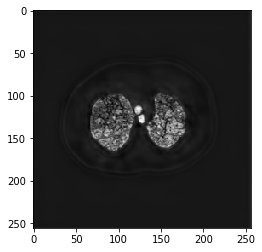

Actual Y


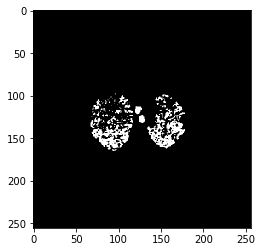

100.0000 --- loss: 0.044172
torch.Size([4, 1, 256, 256])
X


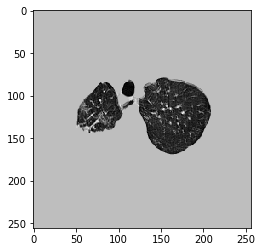

Predicted Y


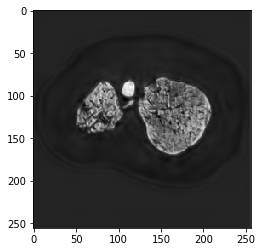

Actual Y


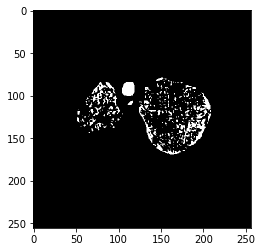

Epoch finished ! Loss: 0.043578654527664185
Checking accuracy on test set
Validation Dice Coeff: 0.06476107984781265
Checkpoint 19 saved !
Starting epoch 20/50.
0.0000 --- loss: 0.031715
torch.Size([4, 1, 256, 256])
X


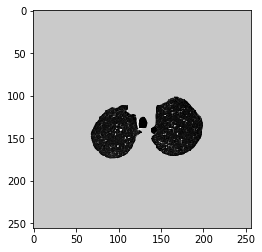

Predicted Y


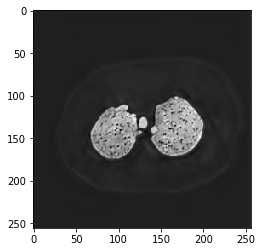

Actual Y


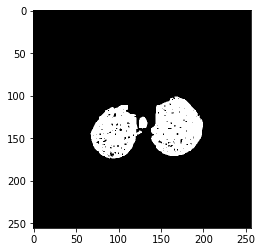

100.0000 --- loss: 0.062623
torch.Size([4, 1, 256, 256])
X


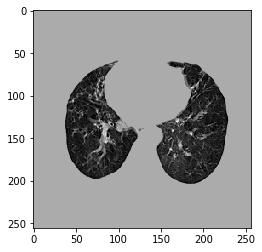

Predicted Y


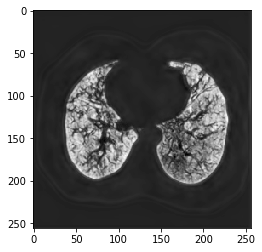

Actual Y


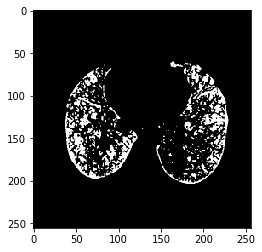

Epoch finished ! Loss: 0.04205925017595291
Checking accuracy on test set
Validation Dice Coeff: 0.023764148354530334
Checkpoint 20 saved !
Starting epoch 21/50.
0.0000 --- loss: 0.045920
torch.Size([4, 1, 256, 256])
X


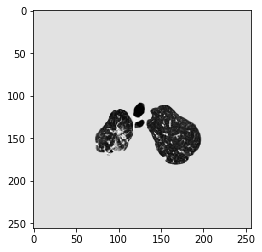

Predicted Y


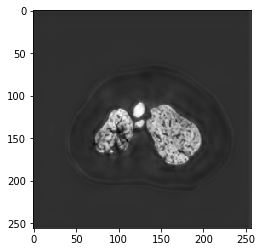

Actual Y


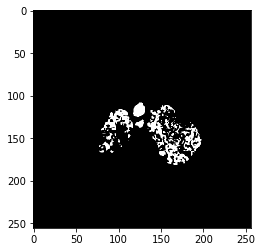

100.0000 --- loss: 0.039140
torch.Size([4, 1, 256, 256])
X


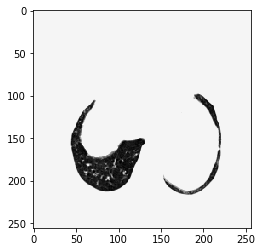

Predicted Y


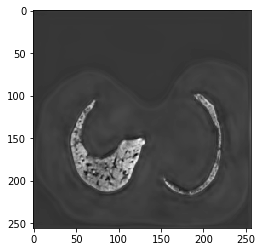

Actual Y


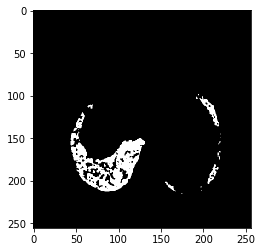

Epoch finished ! Loss: 0.04257642850279808
Checking accuracy on test set
Validation Dice Coeff: 0.042594168335199356
Checkpoint 21 saved !
Starting epoch 22/50.
0.0000 --- loss: 0.041131
torch.Size([4, 1, 256, 256])
X


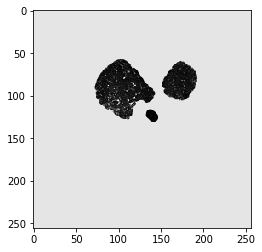

Predicted Y


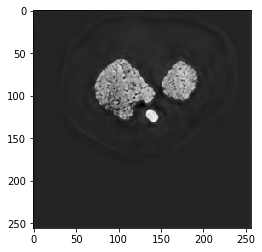

Actual Y


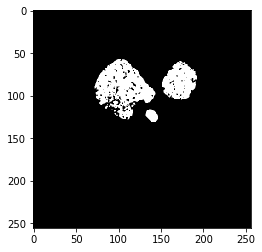

100.0000 --- loss: 0.039894
torch.Size([4, 1, 256, 256])
X


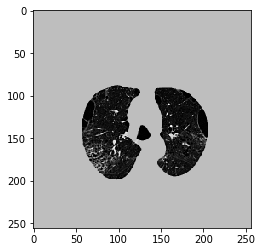

Predicted Y


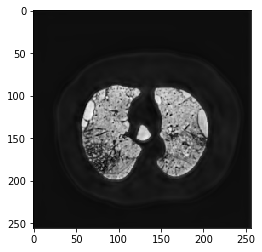

Actual Y


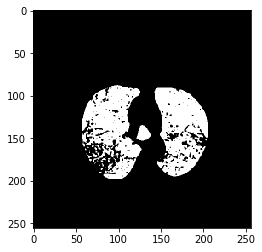

Epoch finished ! Loss: 0.041583072394132614
Checking accuracy on test set
Validation Dice Coeff: 0.010258384048938751
Checkpoint 22 saved !
Starting epoch 23/50.
0.0000 --- loss: 0.037621
torch.Size([4, 1, 256, 256])
X


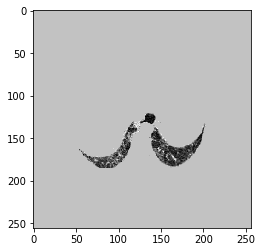

Predicted Y


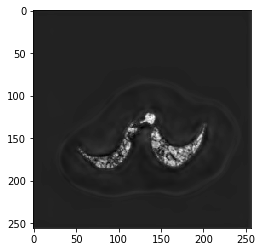

Actual Y


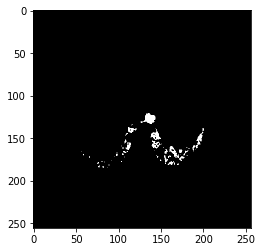

100.0000 --- loss: 0.067011
torch.Size([4, 1, 256, 256])
X


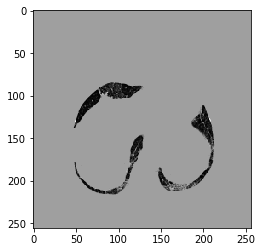

Predicted Y


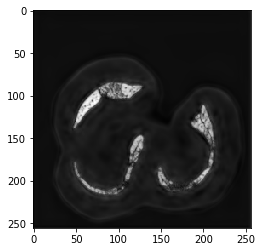

Actual Y


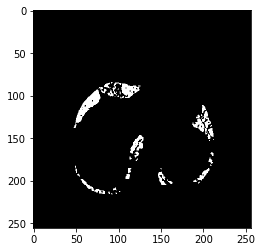

Epoch finished ! Loss: 0.04058898985385895
Checking accuracy on test set
Validation Dice Coeff: 0.04585064575076103
Checkpoint 23 saved !
Starting epoch 24/50.
0.0000 --- loss: 0.037054
torch.Size([4, 1, 256, 256])
X


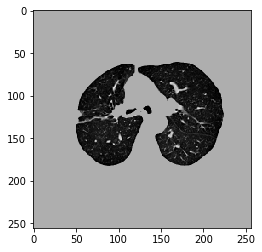

Predicted Y


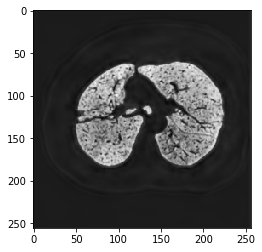

Actual Y


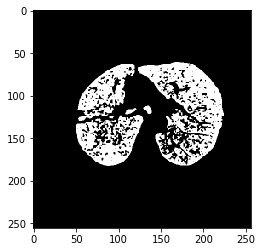

100.0000 --- loss: 0.058890
torch.Size([4, 1, 256, 256])
X


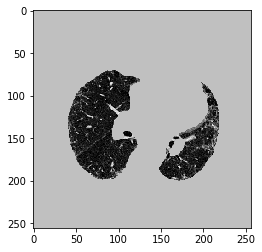

Predicted Y


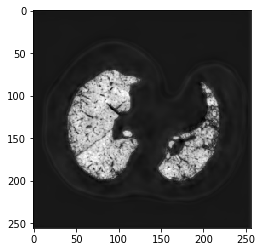

Actual Y


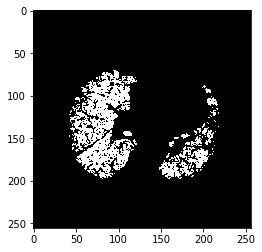

Epoch finished ! Loss: 0.040675632655620575
Checking accuracy on test set
Validation Dice Coeff: 0.05360494554042816
Checkpoint 24 saved !
Starting epoch 25/50.
0.0000 --- loss: 0.038014
torch.Size([4, 1, 256, 256])
X


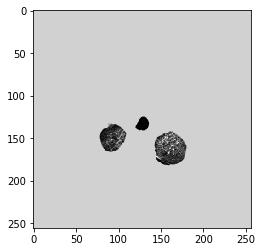

Predicted Y


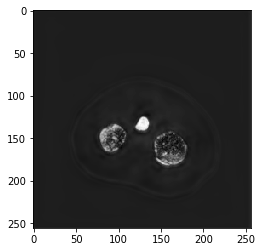

Actual Y


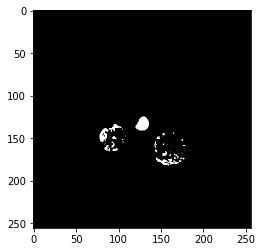

100.0000 --- loss: 0.067933
torch.Size([4, 1, 256, 256])
X


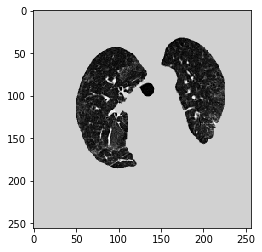

Predicted Y


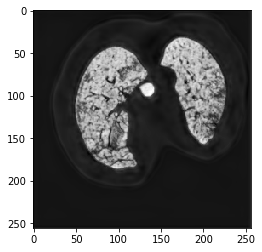

Actual Y


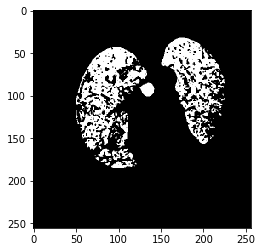

Epoch finished ! Loss: 0.04128804802894592
Checking accuracy on test set
Validation Dice Coeff: 0.09282393753528595
Checkpoint 25 saved !
Starting epoch 26/50.
0.0000 --- loss: 0.032998
torch.Size([4, 1, 256, 256])
X


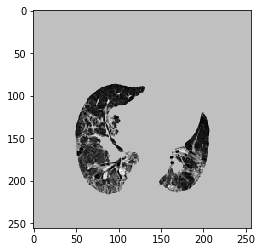

Predicted Y


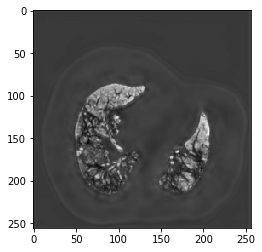

Actual Y


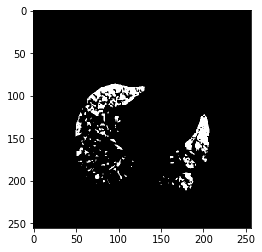

100.0000 --- loss: 0.044125
torch.Size([4, 1, 256, 256])
X


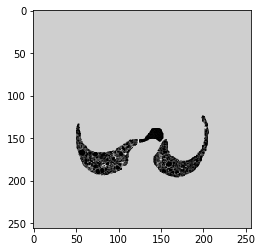

Predicted Y


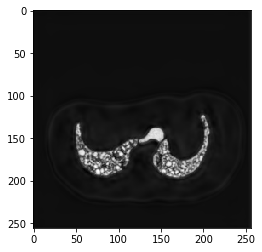

Actual Y


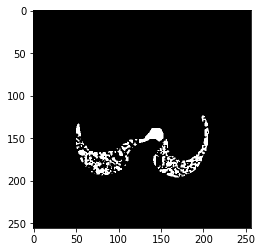

Epoch finished ! Loss: 0.03930334746837616
Checking accuracy on test set
Validation Dice Coeff: 0.03581726551055908
Checkpoint 26 saved !
Starting epoch 27/50.
0.0000 --- loss: 0.044583
torch.Size([4, 1, 256, 256])
X


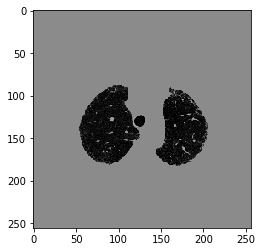

Predicted Y


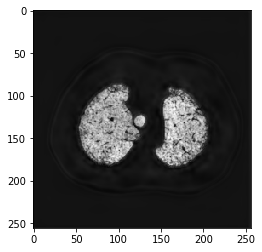

Actual Y


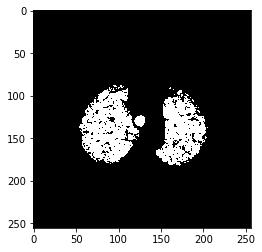

100.0000 --- loss: 0.035910
torch.Size([4, 1, 256, 256])
X


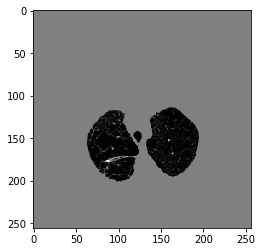

Predicted Y


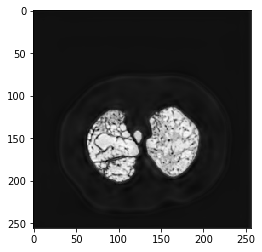

Actual Y


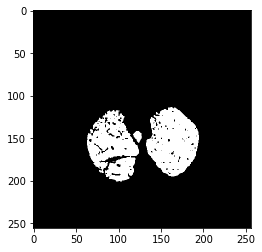

Epoch finished ! Loss: 0.0400397926568985
Checking accuracy on test set
Validation Dice Coeff: 0.02276747114956379
Checkpoint 27 saved !
Starting epoch 28/50.
0.0000 --- loss: 0.035495
torch.Size([4, 1, 256, 256])
X


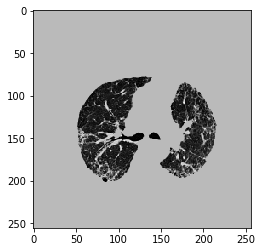

Predicted Y


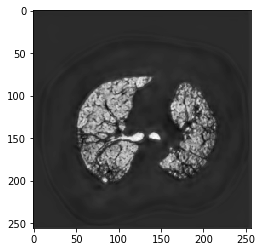

Actual Y


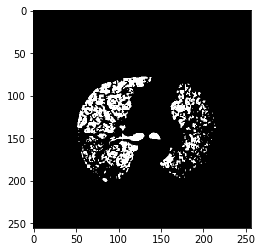

100.0000 --- loss: 0.034546
torch.Size([4, 1, 256, 256])
X


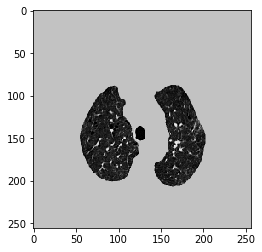

Predicted Y


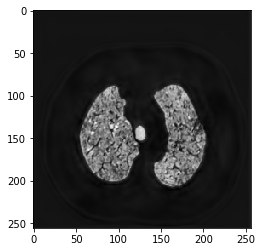

Actual Y


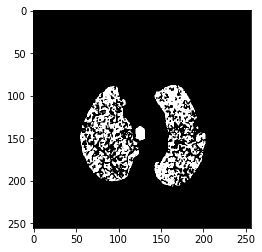

Epoch finished ! Loss: 0.03977752849459648
Checking accuracy on test set
Validation Dice Coeff: 0.043848078697919846
Checkpoint 28 saved !
Starting epoch 29/50.
0.0000 --- loss: 0.054134
torch.Size([4, 1, 256, 256])
X


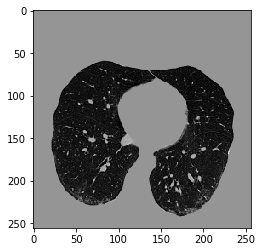

Predicted Y


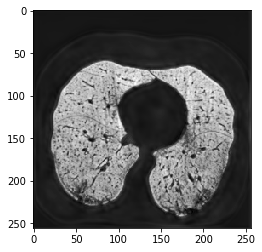

Actual Y


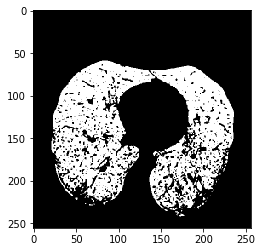

100.0000 --- loss: 0.041490
torch.Size([4, 1, 256, 256])
X


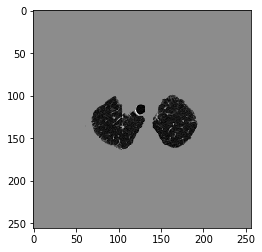

Predicted Y


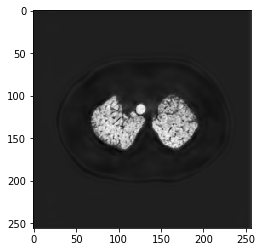

Actual Y


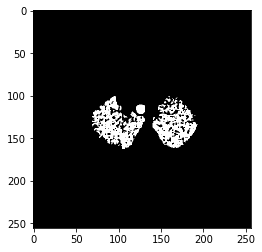

Epoch finished ! Loss: 0.037240542471408844
Checking accuracy on test set
Validation Dice Coeff: 0.05385175347328186
Checkpoint 29 saved !
Starting epoch 30/50.
0.0000 --- loss: 0.041086
torch.Size([4, 1, 256, 256])
X


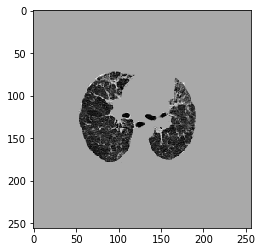

Predicted Y


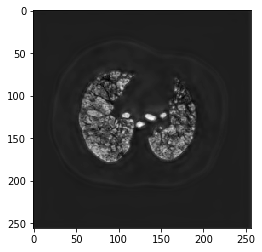

Actual Y


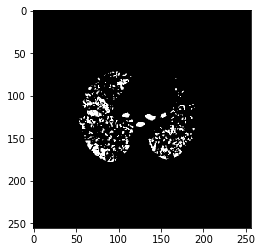

100.0000 --- loss: 0.019002
torch.Size([4, 1, 256, 256])
X


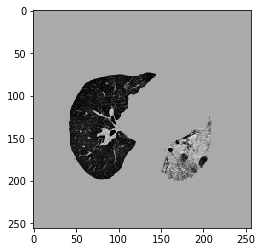

Predicted Y


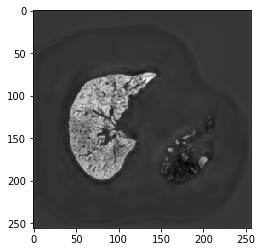

Actual Y


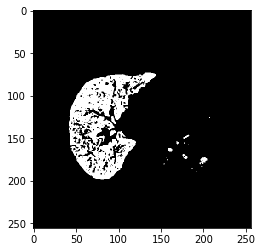

Epoch finished ! Loss: 0.03826933726668358
Checking accuracy on test set
Validation Dice Coeff: 0.11580673605203629
Checkpoint 30 saved !
Starting epoch 31/50.
0.0000 --- loss: 0.037605
torch.Size([4, 1, 256, 256])
X


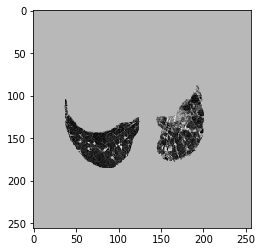

Predicted Y


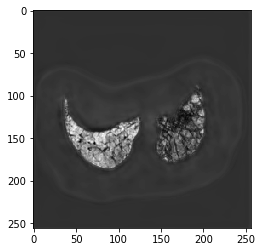

Actual Y


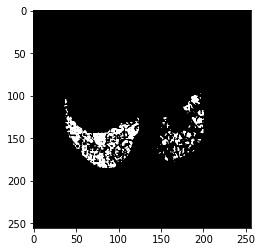

100.0000 --- loss: 0.056853
torch.Size([4, 1, 256, 256])
X


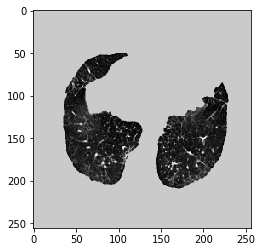

Predicted Y


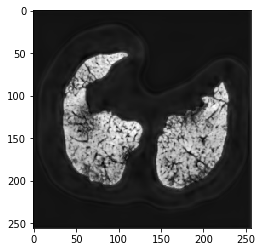

Actual Y


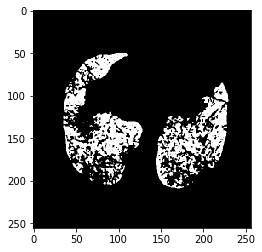

Epoch finished ! Loss: 0.03727935254573822
Checking accuracy on test set
Validation Dice Coeff: 0.025475790724158287
Checkpoint 31 saved !
Starting epoch 32/50.
0.0000 --- loss: 0.031987
torch.Size([4, 1, 256, 256])
X


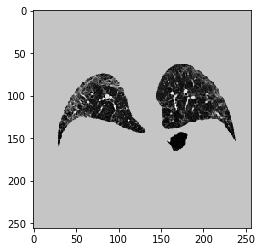

Predicted Y


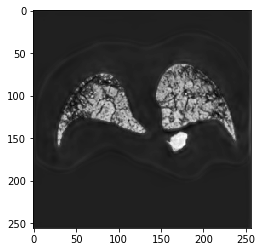

Actual Y


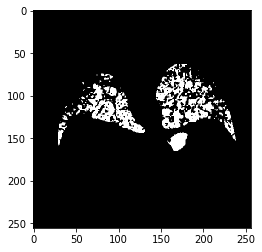

100.0000 --- loss: 0.037487
torch.Size([4, 1, 256, 256])
X


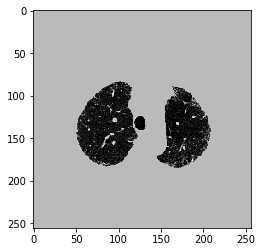

Predicted Y


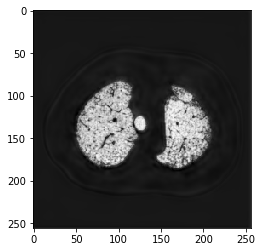

Actual Y


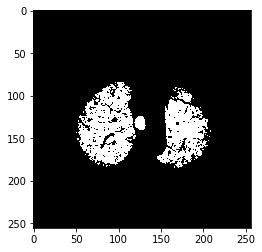

Epoch finished ! Loss: 0.03748133406043053
Checking accuracy on test set
Validation Dice Coeff: 0.01895153522491455
Checkpoint 32 saved !
Starting epoch 33/50.
0.0000 --- loss: 0.023867
torch.Size([4, 1, 256, 256])
X


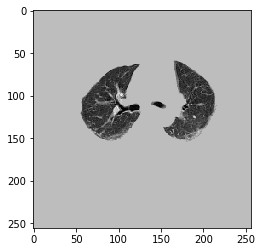

Predicted Y


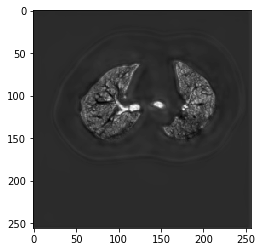

Actual Y


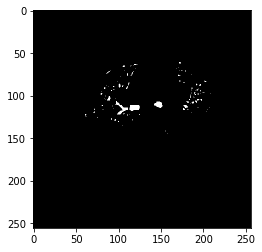

100.0000 --- loss: 0.035201
torch.Size([4, 1, 256, 256])
X


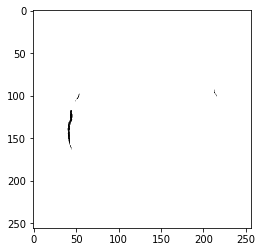

Predicted Y


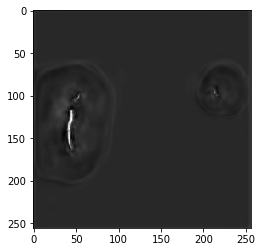

Actual Y


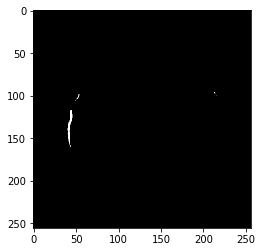

Epoch finished ! Loss: 0.03790905326604843
Checking accuracy on test set
Validation Dice Coeff: 0.01000441238284111
Checkpoint 33 saved !
Starting epoch 34/50.
0.0000 --- loss: 0.039116
torch.Size([4, 1, 256, 256])
X


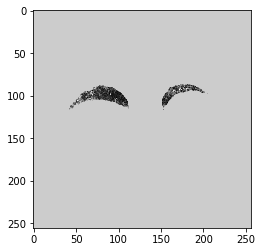

Predicted Y


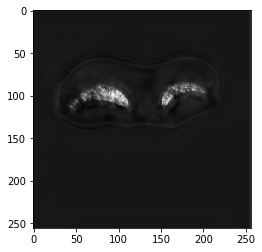

Actual Y


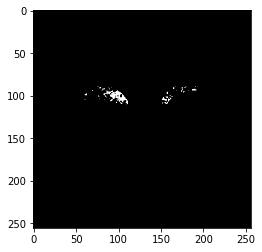

100.0000 --- loss: 0.034155
torch.Size([4, 1, 256, 256])
X


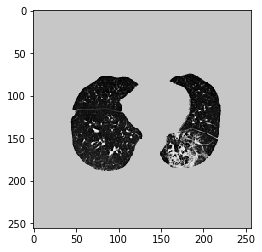

Predicted Y


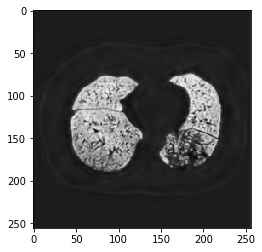

Actual Y


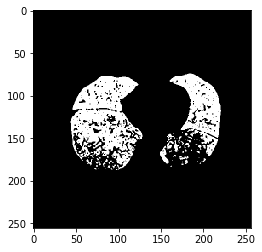

Epoch finished ! Loss: 0.03713944926857948
Checking accuracy on test set
Validation Dice Coeff: 0.046914637088775635
Checkpoint 34 saved !
Starting epoch 35/50.
0.0000 --- loss: 0.027766
torch.Size([4, 1, 256, 256])
X


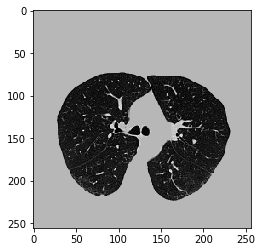

Predicted Y


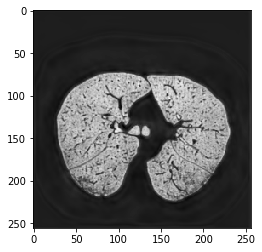

Actual Y


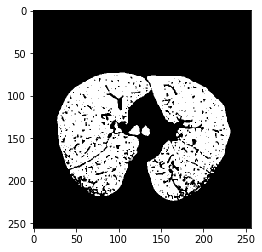

100.0000 --- loss: 0.043912
torch.Size([4, 1, 256, 256])
X


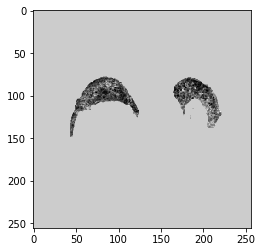

Predicted Y


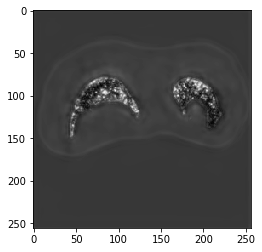

Actual Y


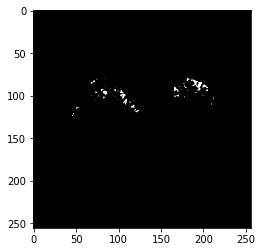

Epoch finished ! Loss: 0.037637632340192795
Checking accuracy on test set
Validation Dice Coeff: 0.0007459584739990532
Checkpoint 35 saved !
Starting epoch 36/50.
0.0000 --- loss: 0.033331
torch.Size([4, 1, 256, 256])
X


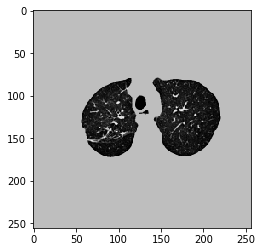

Predicted Y


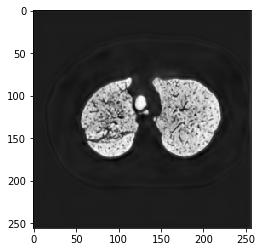

Actual Y


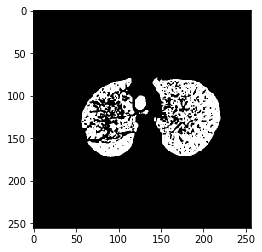

100.0000 --- loss: 0.027700
torch.Size([4, 1, 256, 256])
X


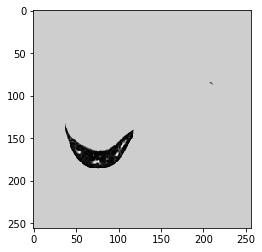

Predicted Y


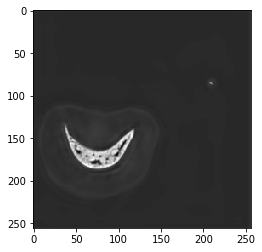

Actual Y


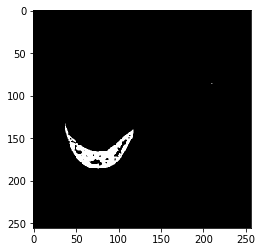

Epoch finished ! Loss: 0.036522217094898224
Checking accuracy on test set
Validation Dice Coeff: 0.029683241620659828
Checkpoint 36 saved !
Starting epoch 37/50.
0.0000 --- loss: 0.026561
torch.Size([4, 1, 256, 256])
X


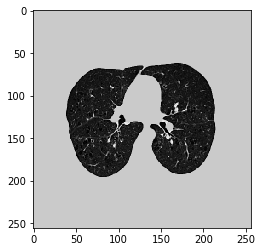

Predicted Y


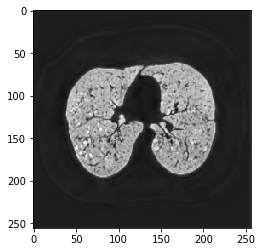

Actual Y


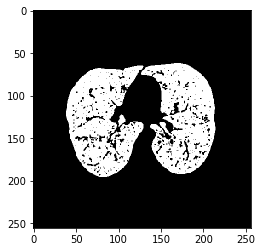

100.0000 --- loss: 0.021035
torch.Size([4, 1, 256, 256])
X


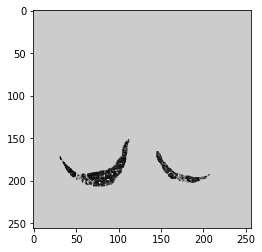

Predicted Y


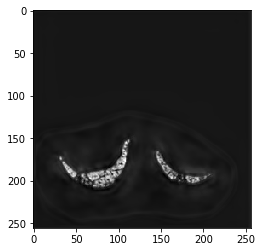

Actual Y


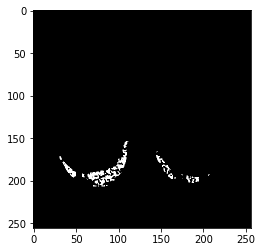

Epoch finished ! Loss: 0.036294125020504
Checking accuracy on test set
Validation Dice Coeff: 0.0806659385561943
Checkpoint 37 saved !
Starting epoch 38/50.
0.0000 --- loss: 0.037652
torch.Size([4, 1, 256, 256])
X


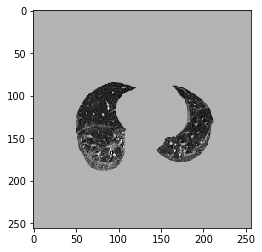

Predicted Y


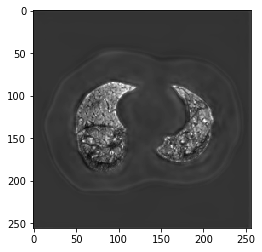

Actual Y


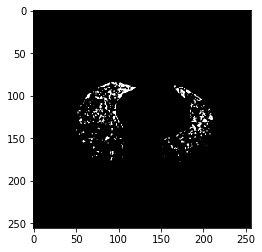

100.0000 --- loss: 0.028486
torch.Size([4, 1, 256, 256])
X


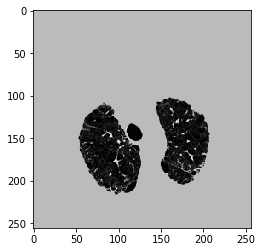

Predicted Y


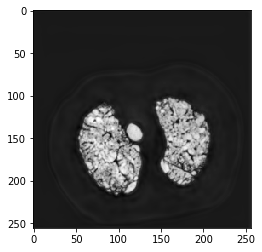

Actual Y


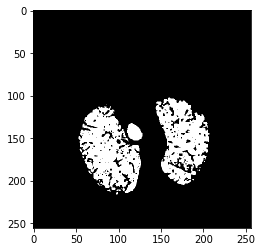

Epoch finished ! Loss: 0.035110924392938614
Checking accuracy on test set
Validation Dice Coeff: 0.022598259150981903
Checkpoint 38 saved !
Starting epoch 39/50.
0.0000 --- loss: 0.038570
torch.Size([4, 1, 256, 256])
X


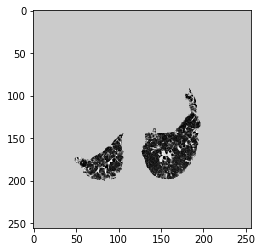

Predicted Y


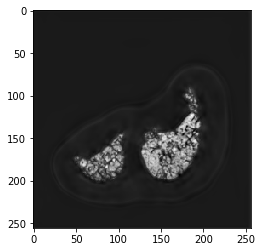

Actual Y


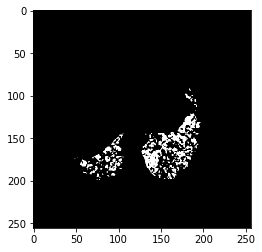

100.0000 --- loss: 0.027126
torch.Size([4, 1, 256, 256])
X


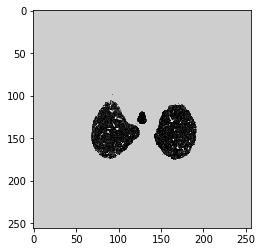

Predicted Y


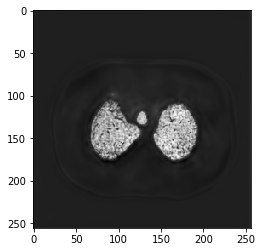

Actual Y


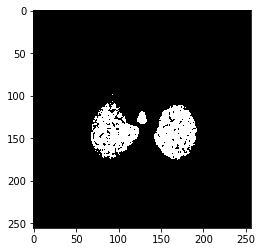

Epoch finished ! Loss: 0.036389801651239395
Checking accuracy on test set
Validation Dice Coeff: 0.03246476128697395
Checkpoint 39 saved !
Starting epoch 40/50.
0.0000 --- loss: 0.031743
torch.Size([4, 1, 256, 256])
X


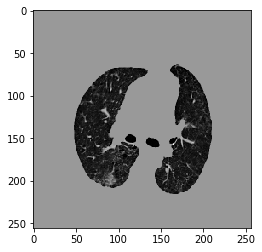

Predicted Y


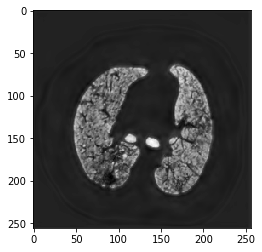

Actual Y


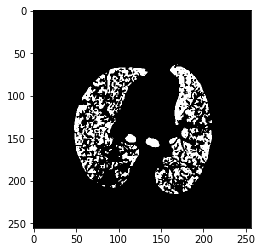

100.0000 --- loss: 0.051930
torch.Size([4, 1, 256, 256])
X


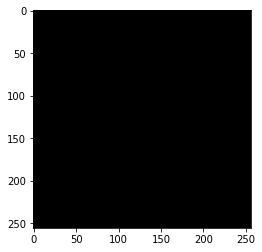

Predicted Y


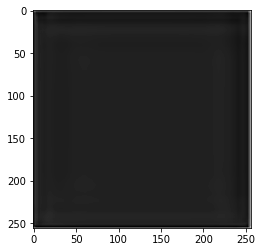

Actual Y


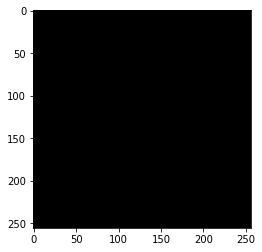

Epoch finished ! Loss: 0.03609423711895943
Checking accuracy on test set
Validation Dice Coeff: 0.052238814532756805
Checkpoint 40 saved !
Starting epoch 41/50.
0.0000 --- loss: 0.061829
torch.Size([4, 1, 256, 256])
X


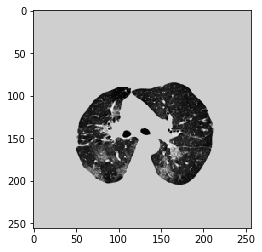

Predicted Y


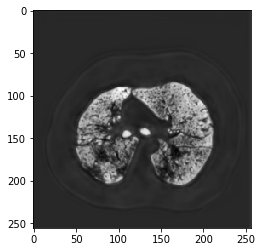

Actual Y


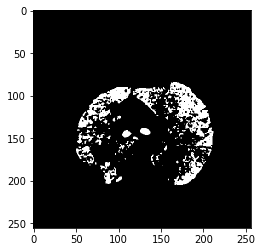

100.0000 --- loss: 0.022519
torch.Size([4, 1, 256, 256])
X


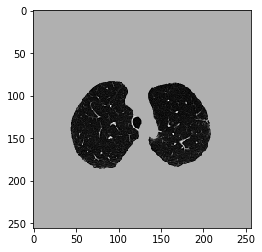

Predicted Y


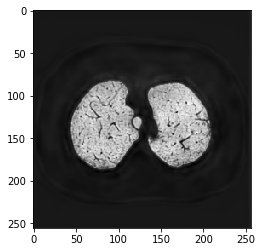

Actual Y


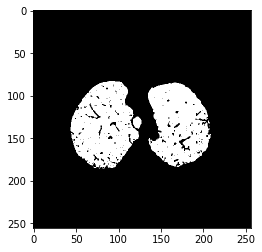

Epoch finished ! Loss: 0.03497486189007759
Checking accuracy on test set
Validation Dice Coeff: 0.03517429903149605
Checkpoint 41 saved !
Starting epoch 42/50.
0.0000 --- loss: 0.026128
torch.Size([4, 1, 256, 256])
X


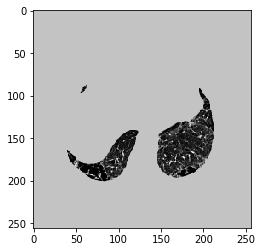

Predicted Y


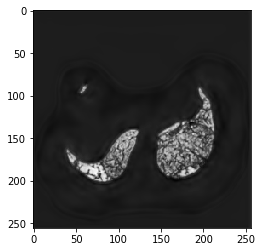

Actual Y


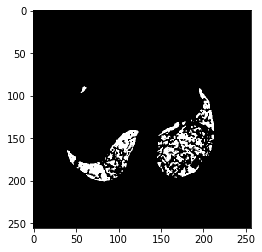

100.0000 --- loss: 0.017190
torch.Size([4, 1, 256, 256])
X


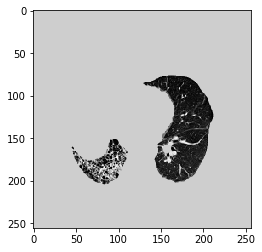

Predicted Y


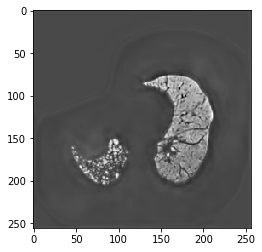

Actual Y


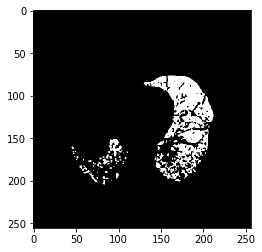

Epoch finished ! Loss: 0.03543893247842789
Checking accuracy on test set
Validation Dice Coeff: 0.026700478047132492
Checkpoint 42 saved !
Starting epoch 43/50.
0.0000 --- loss: 0.034929
torch.Size([4, 1, 256, 256])
X


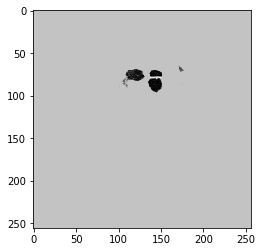

Predicted Y


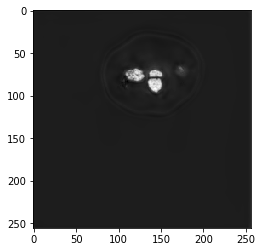

Actual Y


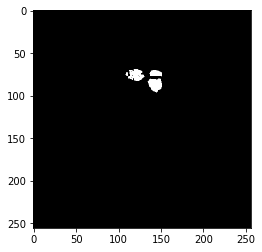

100.0000 --- loss: 0.030854
torch.Size([4, 1, 256, 256])
X


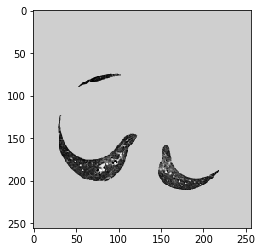

Predicted Y


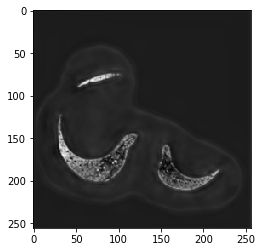

Actual Y


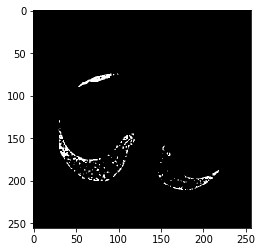

Epoch finished ! Loss: 0.03647466003894806
Checking accuracy on test set
Validation Dice Coeff: 0.05968453735113144
Checkpoint 43 saved !
Starting epoch 44/50.
0.0000 --- loss: 0.026218
torch.Size([4, 1, 256, 256])
X


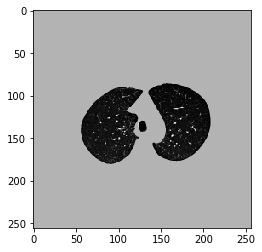

Predicted Y


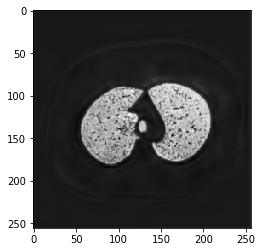

Actual Y


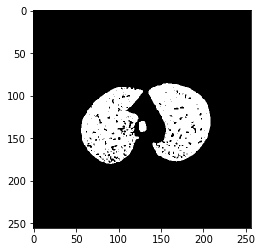

100.0000 --- loss: 0.054330
torch.Size([4, 1, 256, 256])
X


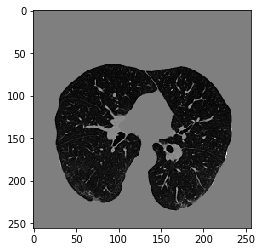

Predicted Y


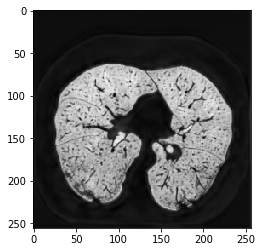

Actual Y


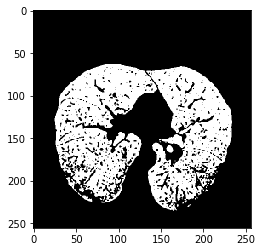

Epoch finished ! Loss: 0.03445832058787346
Checking accuracy on test set
Validation Dice Coeff: 0.01902860403060913
Checkpoint 44 saved !
Starting epoch 45/50.
0.0000 --- loss: 0.028214
torch.Size([4, 1, 256, 256])
X


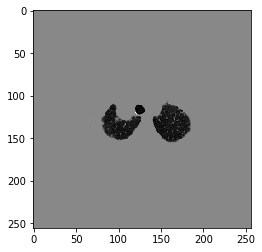

Predicted Y


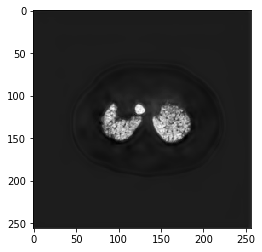

Actual Y


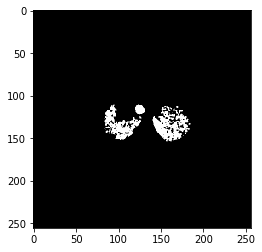

100.0000 --- loss: 0.041450
torch.Size([4, 1, 256, 256])
X


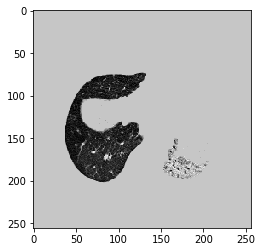

Predicted Y


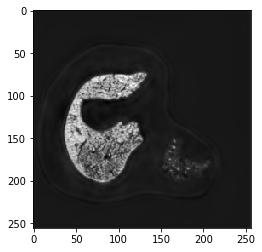

Actual Y


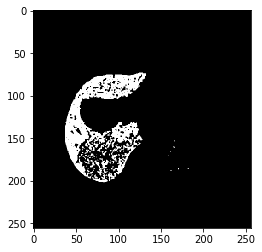

Epoch finished ! Loss: 0.03424524888396263
Checking accuracy on test set
Validation Dice Coeff: 0.05236958712339401
Checkpoint 45 saved !
Starting epoch 46/50.
0.0000 --- loss: 0.041878
torch.Size([4, 1, 256, 256])
X


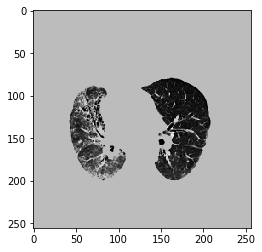

Predicted Y


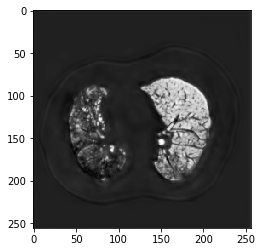

Actual Y


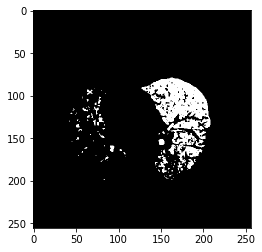

100.0000 --- loss: 0.038124
torch.Size([4, 1, 256, 256])
X


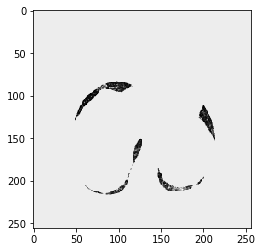

Predicted Y


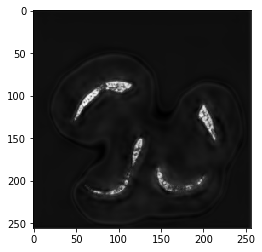

Actual Y


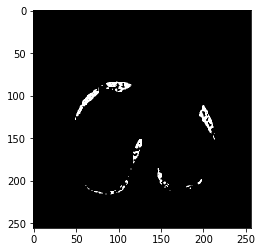

Epoch finished ! Loss: 0.03436156362295151
Checking accuracy on test set
Validation Dice Coeff: 0.02862442284822464
Checkpoint 46 saved !
Starting epoch 47/50.
0.0000 --- loss: 0.031723
torch.Size([4, 1, 256, 256])
X


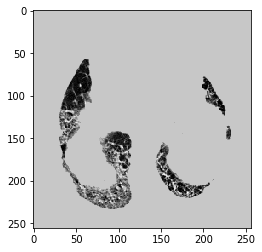

Predicted Y


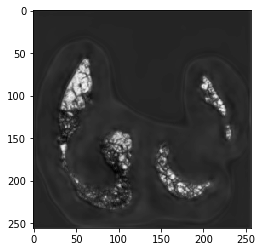

Actual Y


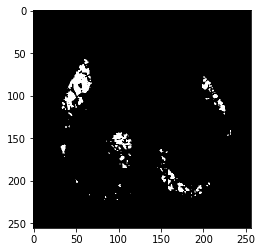

100.0000 --- loss: 0.041965
torch.Size([4, 1, 256, 256])
X


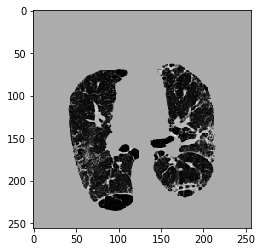

Predicted Y


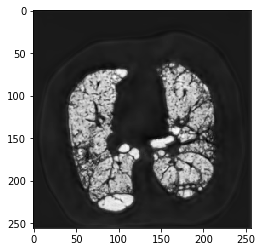

Actual Y


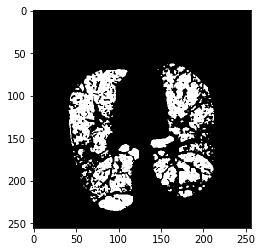

Epoch finished ! Loss: 0.03392794355750084
Checking accuracy on test set
Validation Dice Coeff: 0.05175875499844551
Checkpoint 47 saved !
Starting epoch 48/50.
0.0000 --- loss: 0.040091
torch.Size([4, 1, 256, 256])
X


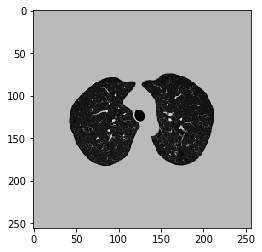

Predicted Y


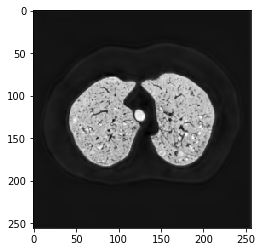

Actual Y


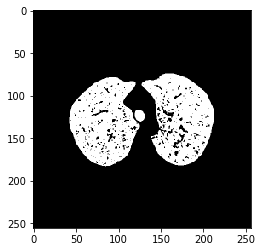

100.0000 --- loss: 0.045215
torch.Size([4, 1, 256, 256])
X


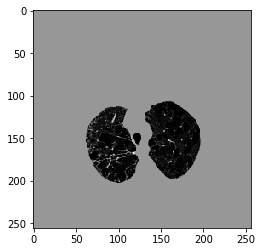

Predicted Y


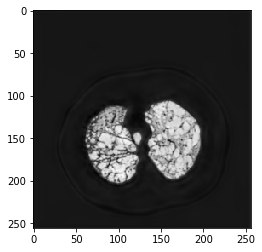

Actual Y


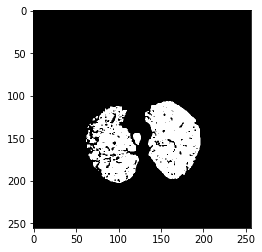

Epoch finished ! Loss: 0.03373783826828003
Checking accuracy on test set
Validation Dice Coeff: 0.07520640641450882
Checkpoint 48 saved !
Starting epoch 49/50.
0.0000 --- loss: 0.026178
torch.Size([4, 1, 256, 256])
X


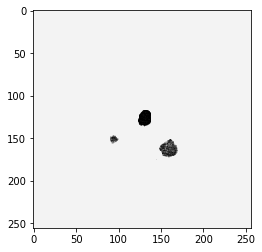

Predicted Y


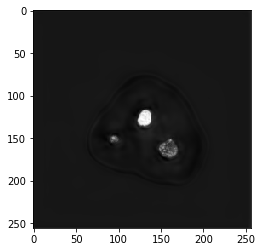

Actual Y


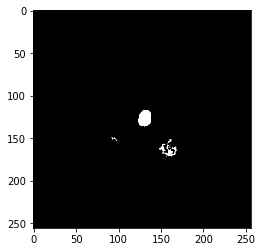

100.0000 --- loss: 0.042534
torch.Size([4, 1, 256, 256])
X


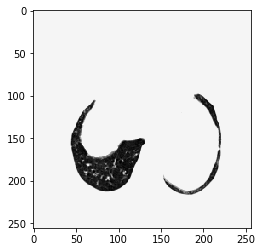

Predicted Y


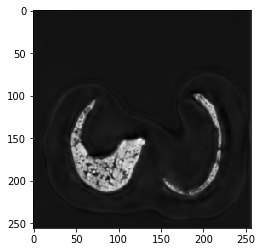

Actual Y


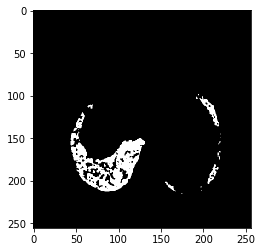

Epoch finished ! Loss: 0.03370526432991028
Checking accuracy on test set
Validation Dice Coeff: 0.07051046192646027
Checkpoint 49 saved !
Starting epoch 50/50.
0.0000 --- loss: 0.035289
torch.Size([4, 1, 256, 256])
X


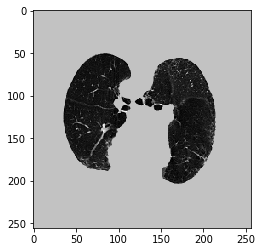

Predicted Y


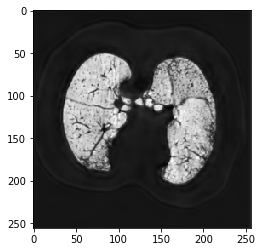

Actual Y


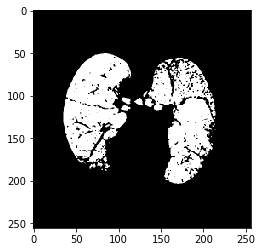

100.0000 --- loss: 0.034873
torch.Size([4, 1, 256, 256])
X


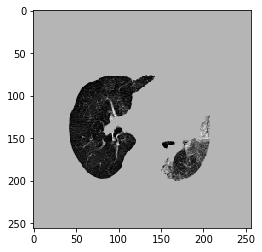

Predicted Y


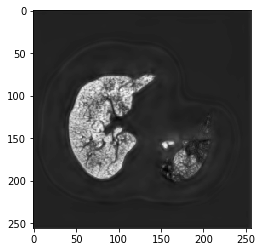

Actual Y


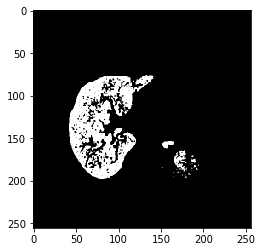

Epoch finished ! Loss: 0.033903636038303375
Checking accuracy on test set
Validation Dice Coeff: 0.04335690289735794
Checkpoint 50 saved !


In [10]:
net = UNet(1, 1)

try:
    train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')